# Tutorial: Introductory Tutorial: Supervised Learning with PINA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial20/tutorial.ipynb)


> ##### ⚠️ ***Before starting:***
> We assume you are already familiar with the concepts covered in the [Getting started with PINA](https://mathlab.github.io/PINA/_tutorial.html#getting-started-with-pina) tutorials. If not, we strongly recommend reviewing them before exploring this advanced topic.

In this tutorial, we will demonstrate a typical use case of **PINA** for Supervised Learning training. We will cover the basics of training a Supervised Solver with PINA, if you want to go further into PINNs look at our dedicated [tutorials](https://mathlab.github.io/PINA/_tutorial.html#supervised-learning) on the topic.

Let's start by importing the useful modules:

In [1]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

import torch
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

from pina import Trainer
from pina.model import FeedForward
from pina.domain import CartesianDomain
from pina.solver import SupervisedSolver
from pina.adaptive_function import AdaptiveSIREN
from pina.problem.zoo import SupervisedProblem

## Building a Neural Implicit Field for a Sphere

In this tutorial, we will construct a **Neural Implicit Field** to learn the **Signed Distance Function (SDF)** of a sphere. The problem is relatively simple: we aim to learn a function $d_\theta$, parameterized by a neural network, that captures the signed distance to the surface of a sphere.

The function $d_\theta(\mathbf{x})$$ should satisfy the following properties:

- $d_\theta(\mathbf{x}) = 0$ on the surface of the sphere  
- $d_\theta(\mathbf{x}) > 0$ outside the sphere  
- $d_\theta(\mathbf{x}) < 0$ inside the sphere  

This setup allows us to implicitly represent the geometry of the sphere through the learned function.

### Mathematical Description

We define the signed distance function (SDF) for a sphere centered at the origin with radius $r$ as:
$d(\mathbf{x}) = \|\mathbf{x}\| - r$, where $\mathbf{x} \in \mathbb{R}^3$ is a point in 3D space.

Our goal is to approximate this function using a neural network: $d_\theta(\mathbf{x}) \approx d(\mathbf{x})$ with a Neural Network. Let's start by generating the data for the problem by:
1. Sample random 3D points within a bounding cube (e.g., $[-1.5, 1.5]^3$).
2. Compute their ground truth signed distances from a sphere of radius $r$ centered at the origin.
3. Package this into tensors for training.

In [2]:
def generate_sdf_data(num_points=1000000, radius=1.0, cube_bound=1.5):
    # Create the 3D cube
    domain = CartesianDomain(
        {
            "x": [-cube_bound, cube_bound],
            "y": [-cube_bound, cube_bound],
            "z": [-cube_bound, cube_bound],
        }
    )
    # Sample random 3D points in cube
    coords = domain.sample(num_points, mode="random").tensor
    # Compute signed distance to the sphere
    sdf = coords.norm(dim=-1, keepdim=True) - radius  # ||x|| - r

    return coords, sdf

### Visualizing the Data

To better understand the problem and the nature of the solutions, we can visualize the generated data:

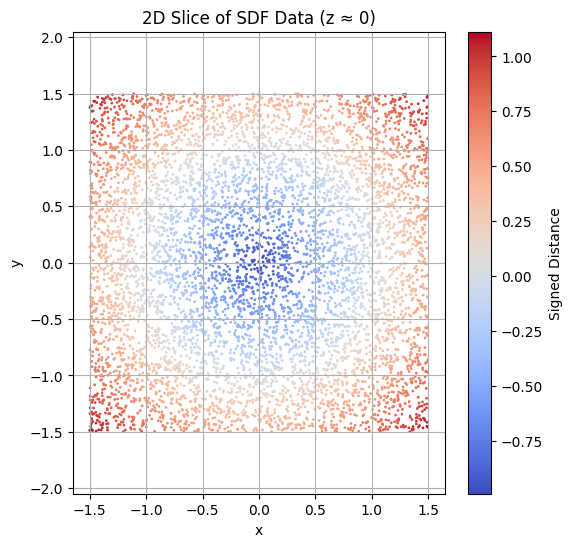

In [3]:
# --- Generate Data ---
coords, sdf = generate_sdf_data()

# --- 2D Slice at z ≈ 0 ---
z_slice_thresh = 0.01  # How close to z=0
mask_2d = coords[:, 2].abs() < z_slice_thresh
coords_2d = coords[mask_2d]
sdf_2d = sdf[mask_2d]

plt.figure(figsize=(6, 6))
plt.scatter(
    coords_2d[:, 0], coords_2d[:, 1], c=sdf_2d.squeeze(), cmap="coolwarm", s=1
)
plt.colorbar(label="Signed Distance")
plt.title("2D Slice of SDF Data (z ≈ 0)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.show()

## Creating the Problem

The problem we will define is a basic `SupervisedProblem`, where the inputs are the coordinates and the outputs are the corresponding Signed Distance Function (SDF) values.

> **👉 We have a dedicated [tutorial](https://mathlab.github.io/PINA/tutorial16/tutorial.html) to teach how to build a Problem from scratch — have a look if you're interested!**

In [4]:
problem = SupervisedProblem(coords, sdf)

## Solving the Problem with Supervised Solver

We will use the `SupervisedSolver` to solve the task. A Supervised Solver in PINA aims to find a mapping between an input \( x \) and an output \( y \).
Given a PINA `model` $\mathcal{M}$, the following loss function is minimized during training:

$$
\mathcal{L}_{\rm{supervised}} = \frac{1}{N}\sum_{i=1}^N \mathcal{l}(y_i, \mathcal{M}(x_i)),
$$

where $l$ is a specific loss function, typically the MSE (Mean Squared Error).

### Specify the Loss Function
By default, the loss function applies a forward pass of the `model` on the input and compares it to the target using the `loss` attribute of `SupervisedSolver`. The [`loss_data`](https://mathlab.github.io/PINA/_rst/solver/supervised.html#pina.solver.supervised.SupervisedSolver.loss_data) function computes the loss for supervised solvers, and it can be overridden by the user to match specific needs (e.g., performing pre-process operations on the input, post-process operations on the output, etc.).

In [ ]:
# Create a model, in our case a simple FeedForward Network
model = FeedForward(input_dimensions=3, output_dimensions=1, func=AdaptiveSIREN)

# Define the solver
solver = SupervisedSolver(problem, model, use_lt=False)

# Simple training
trainer = Trainer(
    solver,
    max_epochs=1,
    train_size=0.8,
    test_size=0.2,
    batch_size=256,
    accelerator="cpu",
    enable_model_summary=False,
)
trainer.train()
_ = trainer.test()

## Visualizing the Predictions

As we can see, we have achieved a very low MSE, even after training for only one epoch. Now, we will visualize the results in the same way as we did previously:

We will plot the predicted Signed Distance Function (SDF) values alongside the true SDF values to evaluate the model's performance.

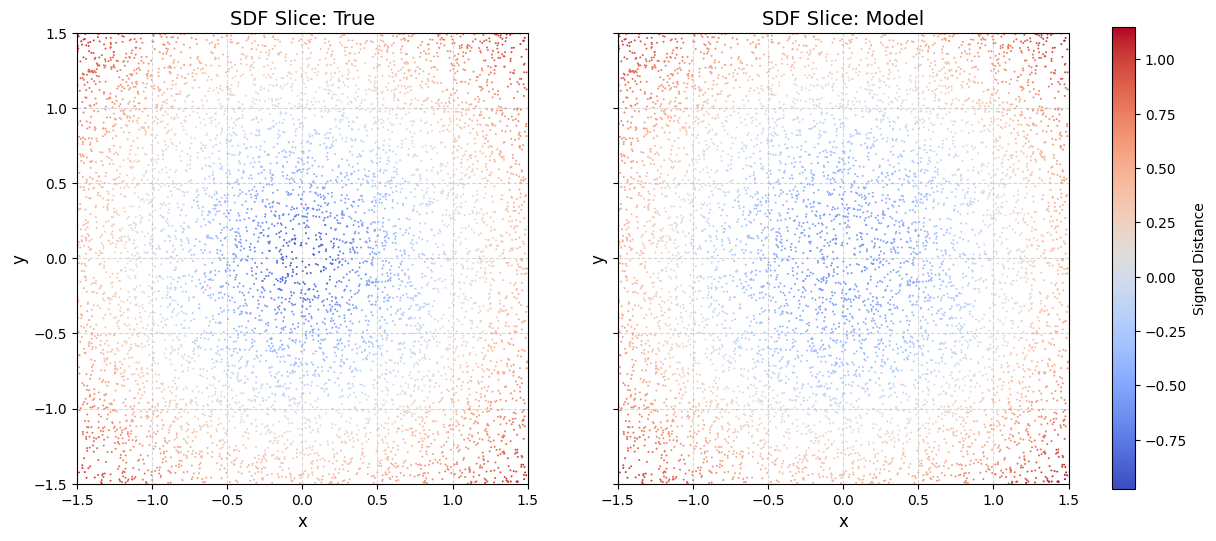

In [6]:
import torch
import matplotlib.pyplot as plt

# --- Generate new Data ---
coords, sdf = generate_sdf_data()

# --- 2D Slice at z ≈ 0 ---
z_slice_thresh = 0.01  # How close to z=0
mask_2d = coords[:, 2].abs() < z_slice_thresh
coords_2d = coords[mask_2d]
true_sdf = sdf[mask_2d]
model_sdf = solver(coords).detach()[mask_2d]

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Create a common color normalization for both subplots
vmin = min(true_sdf.min(), model_sdf.min())
vmax = max(true_sdf.max(), model_sdf.max())
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# Plot the data on both subplots
for idx, sdf_2d in enumerate([true_sdf, model_sdf]):
    ax = axes[idx]

    # Plot the scatter for the SDF values with shared color normalization
    sc = ax.scatter(
        coords_2d[:, 0],
        coords_2d[:, 1],
        c=sdf_2d.squeeze(),
        cmap="coolwarm",
        s=2,
        edgecolors="none",
        norm=norm,
    )

    ax.set_title(f"SDF Slice: {'True' if idx == 0 else 'Model'}", fontsize=14)
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_xlim([-1.5, 1.5])  # Set consistent axis limits
    ax.set_ylim([-1.5, 1.5])  # for both plots to have the same scale
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_aspect("equal", "box")  # Make sure the plot is square

# Add a colorbar for the entire figure (shared between both plots)
fig.colorbar(sc, ax=axes, label="Signed Distance", fraction=0.046, pad=0.04)

# Title and layout adjustments
plt.show()

Nice! We can see that the network is correctly learning the signed distance function! Let's now visualize the rendering of the sphere surface learned by the network.

### Visualizing the Sphere Surface

To visualize the surface, we will extract the level set where the SDF equals zero and plot the resulting sphere. This will show how well the network has learned the geometry of the object.

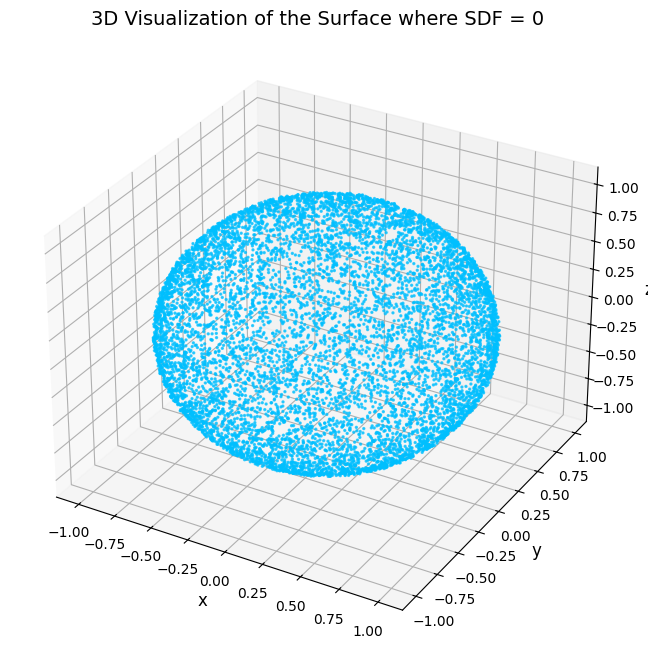

In [7]:
# --- Generate new Data ---
coords, sdf = generate_sdf_data()

# Find points where SDF is approximately 0
zero_sdf_mask = torch.abs(sdf) < 0.01  # Adjust the threshold as needed
zero_sdf_coords = coords[zero_sdf_mask.flatten()]

# --- 3D Plot ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the black points where SDF is 0 (the surface)
ax.scatter(
    zero_sdf_coords[:, 0],
    zero_sdf_coords[:, 1],
    zero_sdf_coords[:, 2],
    c="deepskyblue",
    s=2,
    label="SDF = 0",
    alpha=0.7,
)

# Labels and title
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_zlabel("z", fontsize=12)
ax.set_title("3D Visualization of the Surface where SDF = 0", fontsize=14)
ax.grid(True)
plt.show()

## What's Next?

Congratulations on completing the introductiory tutorial on supervised solver! Now that you have a solid foundation, here are a few directions you can explore:


1. **Experiment with Training Duration & Network Architecture**: Try different training durations and tweak the network architecture to optimize performance.

2. **Explore Other Models in `pina.model`**: Check out other models available in `pina.model` or design your own custom PyTorch module to suit your needs.

3. **... and many more!**: The possibilities are vast! Continue experimenting with advanced configurations, solvers, and other features in PINA.

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).